# Process CAS04 -- Multi Station

See notebook in mth5 for making the h5 file here:


In [1]:
#%matplotlib notebook 
%matplotlib widget


In [2]:
#Imports
import pandas as pd
import pathlib
import os
#from aurora.sandbox.mth5_channel_summary_helpers import channel_summary_to_make_mth5
from aurora.pipelines.run_summary import RunSummary
#from aurora.config import BANDS_DEFAULT_FILE
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.transfer_function.kernel_dataset import KernelDataset
from mth5.utils.helpers import initialize_mth5

In [3]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

In [4]:
#mth5_path = pathlib.Path.home().joinpath("software/irismt/mth5/docs/examples/notebooks/8P_CAS04_NVR08_REV06.h5")
mth5_path = pathlib.Path.home().joinpath("software/irismt/mth5/docs/examples/notebooks/8P_CAS04_NVR08.h5")

In [5]:
m = initialize_mth5(mth5_path)
m.channel_summary.summarize()
df = m.channel_summary.to_dataframe()
df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,ey,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
2,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
3,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,hy,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,103.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
4,CONUS SoCal,CAS04,a,37.633351,-121.468382,329.3875,hz,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,0.0,90.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,CONUS_South,NVR08,NVR08c,38.326630,-118.082382,1375.4250,ex,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,1,0.0,electric,12.6,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
66,CONUS_South,NVR08,NVR08c,38.326630,-118.082382,1375.4250,ey,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,1,0.0,electric,102.6,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
67,CONUS_South,NVR08,NVR08c,38.326630,-118.082382,1375.4250,hx,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,1,0.0,magnetic,12.6,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
68,CONUS_South,NVR08,NVR08c,38.326630,-118.082382,1375.4250,hy,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,1,0.0,magnetic,102.6,0.0,none,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


In [6]:
df.station.unique()

array(['CAS04', 'NVR08'], dtype=object)

In [7]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
run_summary = mth5_run_summary.clone()
run_summary.df

2024-03-04T19:59:12.064603-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/docs/examples/notebooks/8P_CAS04_NVR08.h5


,survey,station_id,run_id,start,end,sample_rate,input_channels,output_channels,channel_scale_factors,valid,mth5_path
0,CONUS SoCal,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/software/irismt/mth5/docs/examp...
1,CONUS SoCal,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/software/irismt/mth5/docs/examp...
2,CONUS SoCal,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/software/irismt/mth5/docs/examp...
3,CONUS SoCal,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/software/irismt/mth5/docs/examp...
4,CONUS SoCal,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/software/irismt/mth5/docs/examp...
5,CONUS SoCal,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-14 16:56:02+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/software/irismt/mth5/docs/examp...
6,CONUS SoCal,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,1.0,"[hx, hy]","[ex, ey, hz]","{'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0, '...",True,/home/kkappler/software/irismt/mth5/docs/examp...


In [8]:
coverage_short_list_columns = ["survey", 'station_id', 'run_id', 'start', 'end', ]
run_summary.df[coverage_short_list_columns]

,survey,station_id,run_id,start,end
0,CONUS SoCal,CAS04,a,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00
1,CONUS SoCal,CAS04,b,2020-06-02 22:24:55+00:00,2020-06-12 17:52:23+00:00
2,CONUS SoCal,CAS04,c,2020-06-12 18:32:17+00:00,2020-07-01 17:32:59+00:00
3,CONUS SoCal,CAS04,d,2020-07-01 19:36:55+00:00,2020-07-13 19:00:00+00:00
4,CONUS SoCal,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00
5,CONUS SoCal,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-14 16:56:02+00:00
6,CONUS SoCal,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00


In [9]:
kernel_dataset = KernelDataset()
station_id = "CAS04"
remote_reference_id = "NVR08"
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,CONUS SoCal,CAS04,b,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,2860.0
1,CONUS SoCal,NVR08,a,2020-06-03 19:10:11+00:00,2020-06-03 19:57:51+00:00,2860.0
2,CONUS SoCal,CAS04,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00,769090.0
3,CONUS SoCal,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00,769090.0
4,CONUS SoCal,CAS04,c,2020-06-12 18:32:17+00:00,2020-06-14 16:56:02+00:00,167025.0
5,CONUS SoCal,NVR08,b,2020-06-12 18:32:17+00:00,2020-06-14 16:56:02+00:00,167025.0
6,CONUS SoCal,CAS04,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,856502.0
7,CONUS SoCal,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00,856502.0


In [10]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_id, remote_reference_id)
cutoff_duration_in_seconds = 180000
kernel_dataset.drop_runs_shorter_than(cutoff_duration_in_seconds)
kernel_dataset.df[coverage_short_list_columns]

,survey,station_id,run_id,start,end
0,CONUS SoCal,CAS04,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00
1,CONUS SoCal,NVR08,b,2020-06-03 20:14:13+00:00,2020-06-12 17:52:23+00:00
2,CONUS SoCal,CAS04,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00
3,CONUS SoCal,NVR08,c,2020-06-14 18:00:44+00:00,2020-06-24 15:55:46+00:00


In [11]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset,) 
#                                       emtf_band_file=BANDS_DEFAULT_FILE,)

2024-03-04T19:59:12.184528-0800 | INFO | aurora.config.config_creator | determine_band_specification_style | Bands not defined; setting to EMTF BANDS_DEFAULT_FILE


In [12]:
config

{
    "processing": {
        "band_setup_file": "/home/kkappler/software/irismt/aurora/aurora/config/emtf_band_setup/bs_test.cfg",
        "band_specification_style": "EMTF",
        "channel_nomenclature.ex": "ex",
        "channel_nomenclature.ey": "ey",
        "channel_nomenclature.hx": "hx",
        "channel_nomenclature.hy": "hy",
        "channel_nomenclature.hz": "hz",
        "decimations": [
            {
                "decimation_level": {
                    "anti_alias_filter": "default",
                    "bands": [
                        {
                            "band": {
                                "center_averaging_type": "geometric",
                                "closed": "left",
                                "decimation_level": 0,
                                "frequency_max": 0.23828125,
                                "frequency_min": 0.19140625,
                                "index_max": 30,
                                "index_min": 25
 

# Add Logic to save FCs

In [13]:
for dec_level in config.decimations:
    dec_level.window.type = "hamming"
#    dec_level.window.overlap = int(dec_level.window.num_samples/4)
    #dec_level.save_fcs = True
    #dec_level.save_fcs_type = "h5"

In [14]:
file_info = os.stat(mth5_path)
print(file_info)
print(file_info.st_size)

os.stat_result(st_mode=33204, st_ino=89318680, st_dev=66306, st_nlink=1, st_uid=1001, st_gid=1001, st_size=107600969, st_atime=1709611152, st_mtime=1709611152, st_ctime=1709611152)
107600969


In [15]:
tf_file_base = f"{station_id}_RR{remote_reference_id}"

2024-03-04T19:59:12.318395-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | Processing Summary Dataframe:
2024-03-04T19:59:12.323588-0800 | INFO | aurora.pipelines.transfer_function_kernel | show_processing_summary | 
         survey station_id run_id  valid  remote  duration    fc dec_level  dec_factor  sample_rate  window_duration  num_samples_window  num_samples  num_stft_windows
0   CONUS SoCal      CAS04      b   True   False  769090.0  None         0         1.0     1.000000            128.0                 128     769090.0            8011.0
1   CONUS SoCal      CAS04      b   True   False  769090.0  None         1         4.0     0.250000            512.0                 128     192272.0            2002.0
2   CONUS SoCal      CAS04      b   True   False  769090.0  None         2         4.0     0.062500           2048.0                 128      48068.0             500.0
3   CONUS SoCal      CAS04      b   True   False  769090.0  None         3 

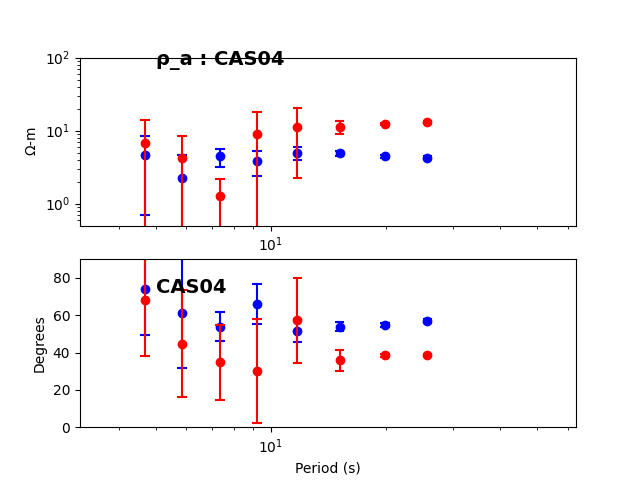

2024-03-04T19:59:22.826150-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 1
2024-03-04T19:59:23.127115-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 1 Successfully
2024-03-04T19:59:23.526473-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:23.941978-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:24.295253-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:24.714588-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:24.739296-0800 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_

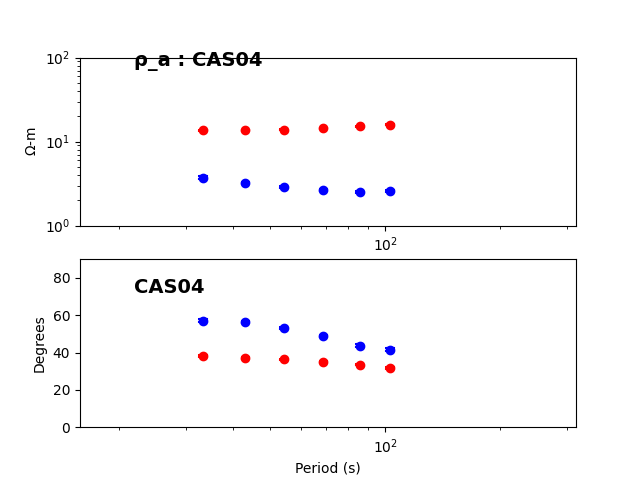

2024-03-04T19:59:26.115629-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 2
2024-03-04T19:59:26.216064-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 2 Successfully
2024-03-04T19:59:26.516022-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:26.848099-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:27.113313-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:27.460911-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:27.477872-0800 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_

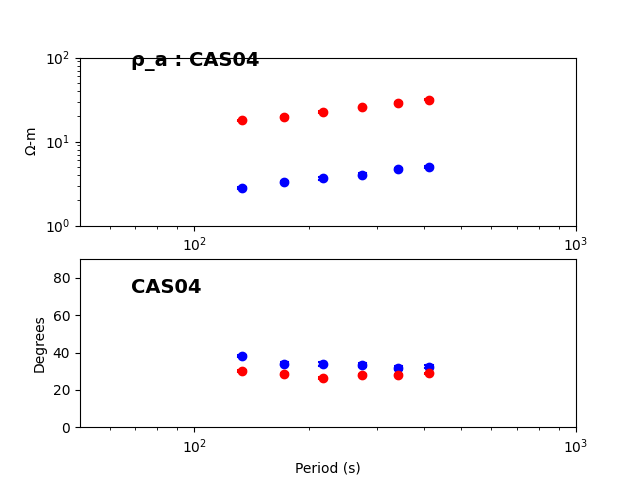

2024-03-04T19:59:28.566827-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | DECIMATION LEVEL 3
2024-03-04T19:59:28.619961-0800 | INFO | aurora.pipelines.transfer_function_kernel | update_dataset_df | Dataset Dataframe Updated for decimation level 3 Successfully
2024-03-04T19:59:28.901712-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:29.216326-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:29.534668-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:29.858168-0800 | INFO | aurora.pipelines.process_mth5 | save_fourier_coefficients | Skip saving FCs. dec_level_config.save_fc =  False
2024-03-04T19:59:29.870741-0800 | INFO | aurora.time_series.frequency_band_helpers | get_band_for_tf_

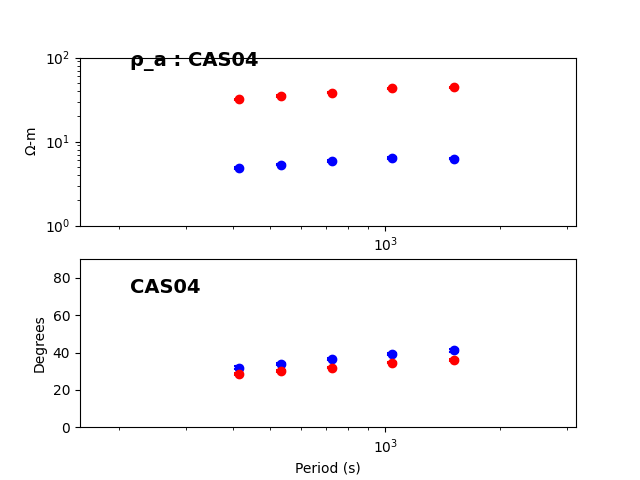

2024-03-04T19:59:30.867164-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/docs/examples/notebooks/8P_CAS04_NVR08.h5
2024-03-04T19:59:31.028006-0800 | INFO | mth5.mth5 | close_mth5 | Flushing and closing /home/kkappler/software/irismt/mth5/docs/examples/notebooks/8P_CAS04_NVR08.h5


In [16]:
show_plot = True
z_file_path = pathlib.Path(f"{tf_file_base}.zrr")
tf_cls = process_mth5(config,
                    kernel_dataset,
                    units="MT",
                    show_plot=show_plot,
                    z_file_path=z_file_path,
                )

In [17]:
tf_cls.write(fn=f"{tf_file_base}.xml", file_type="emtfxml")
tf_cls.write(fn=f"{tf_file_base}.edi", file_type="edi")
tf_cls.write(fn=f"{tf_file_base}.zrr", file_type="zrr")

MT( station='CAS04', latitude=37.63, longitude=-121.47, elevation=329.39 )

In [18]:
archived_z_file = pathlib.Path(f"CAS04bcd_REV06.zrr")

In [19]:
from aurora.transfer_function.plot.comparison_plots import compare_two_z_files
# compare_two_z_files(archived_z_file, f"{tf_file_base}.zrr")
z_file_path = "CAS04_RRNVR08.zrr"

24:03:04T20:02:09 | INFO | line:53 |aurora.transfer_function.plot.comparison_plots | compare_two_z_files | scale_factor1: 1


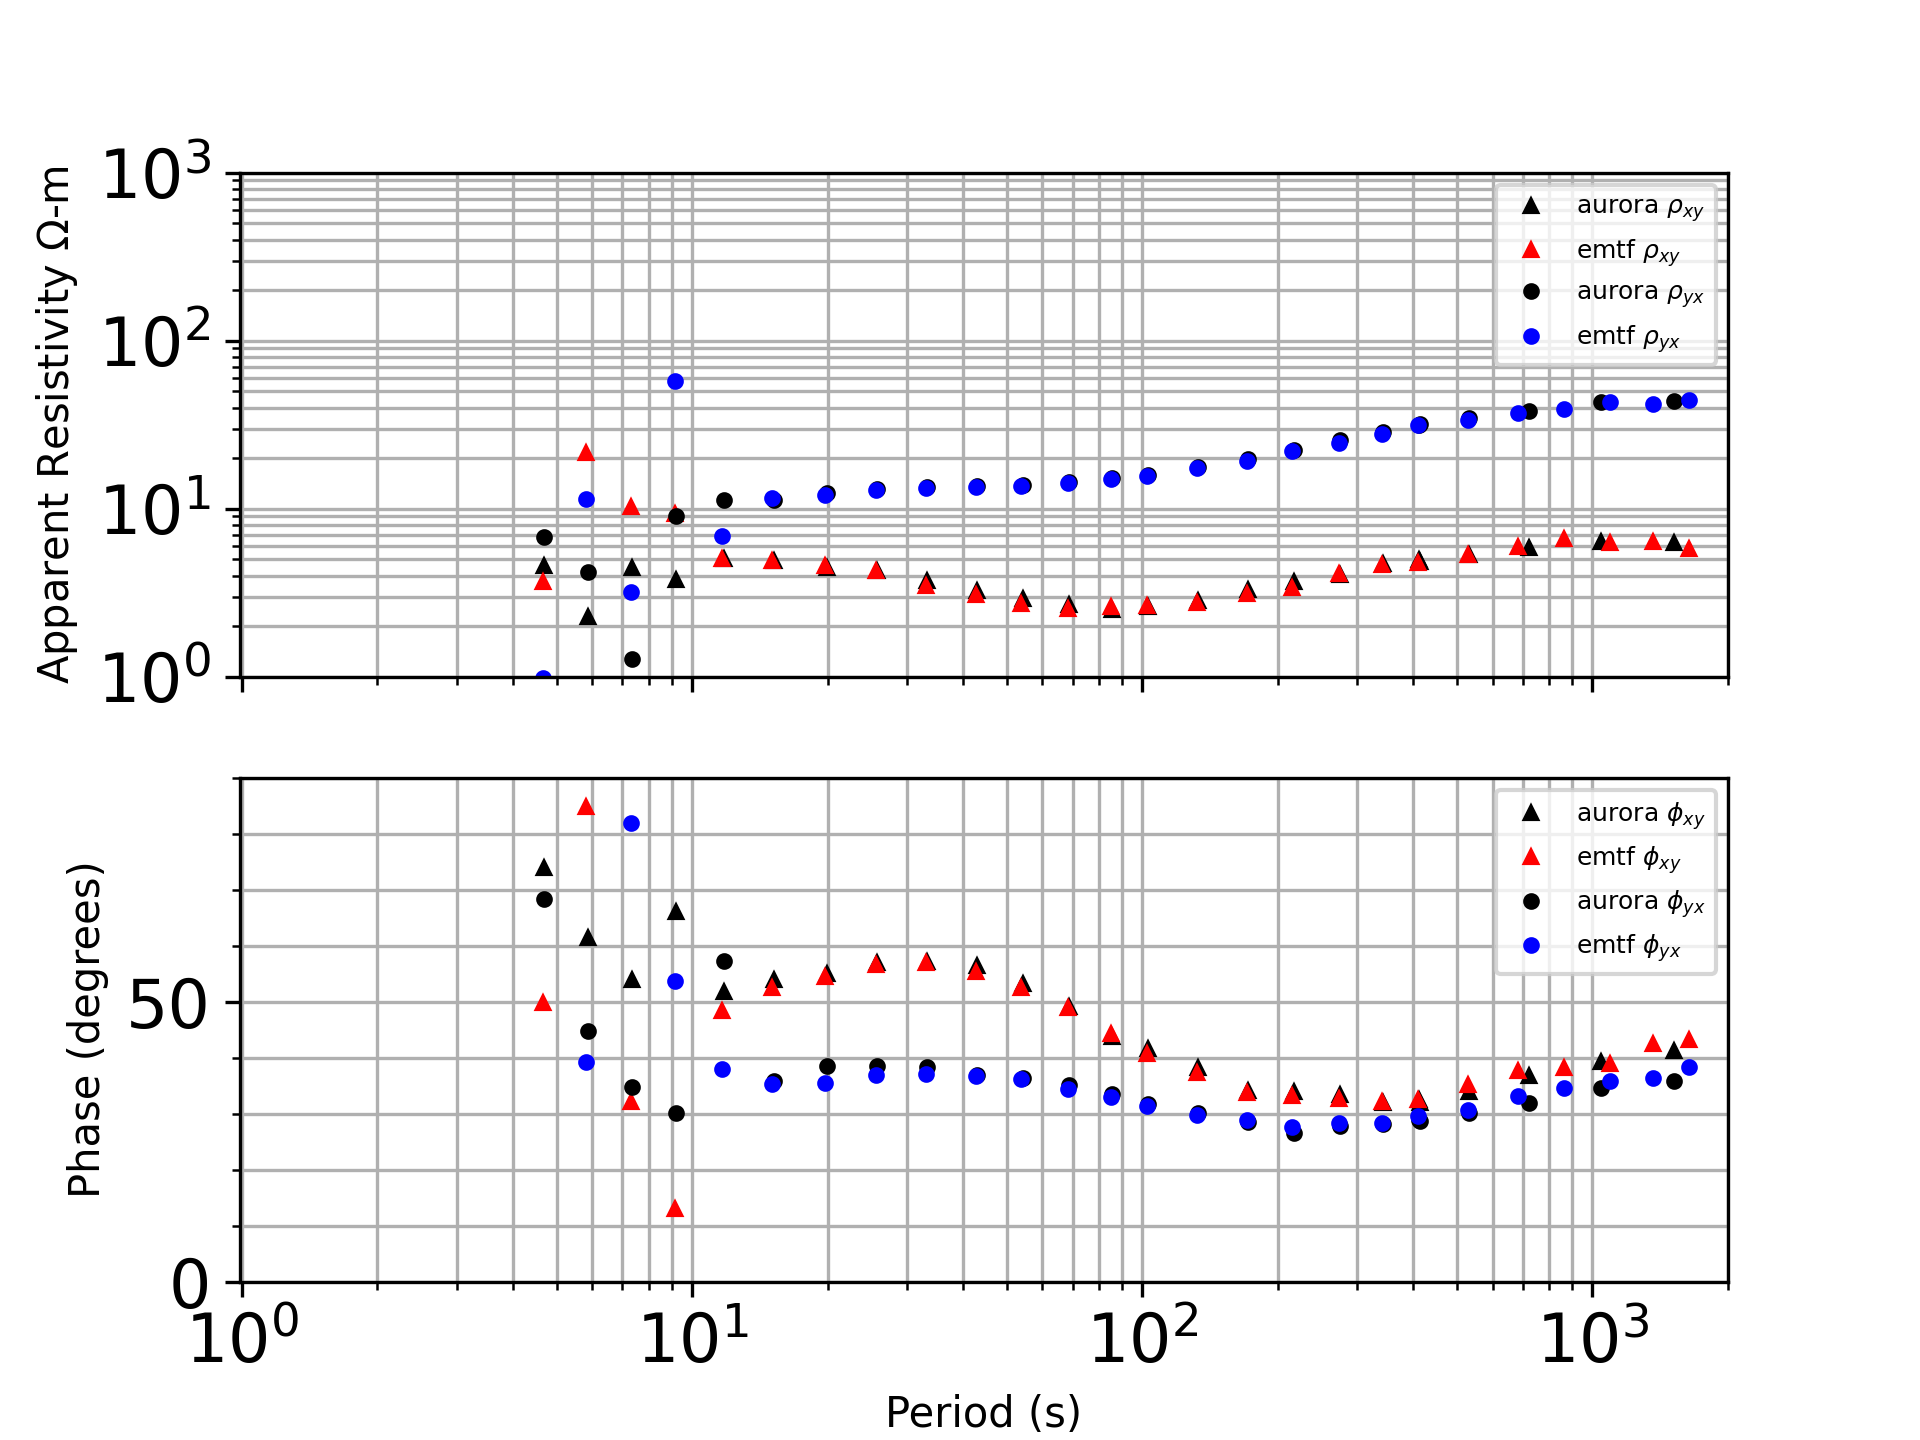

In [26]:
compare_two_z_files(
            z_file_path,
            archived_z_file,
            label1="aurora",
            label2="emtf",
            scale_factor1=1,
            out_file=f"{tf_file_base}compare.png",
            markersize=3,
            rho_ylims=[1e0, 1e3],
            xlims=[0.99, 2000],
        )

#  To compare with the archived file, we need to set the coordinate system to geographic

The TF will be output with a header like this:

```
TRANSFER FUNCTIONS IN MEASUREMENT COORDINATES
********* WITH FULL ERROR COVARIANCE ********
Aurora Robust Remote Reference
station: CAS04
coordinate    37.633  -121.468 declination    13.17
number of channels    5  number of frequencies  25
 orientations and tilts of each channel
    1    13.20     0.00 CAS04  Hx
    2   103.20     0.00 CAS04  Hy
    3     0.00    90.00 CAS04  Hz
    4    13.20     0.00 CAS04  Ex
    5   103.20     0.00 CAS04  Ey
```

To remove the rotation, we can use a variety of tools, but another way is just to overwrite the orientations:

```
TRANSFER FUNCTIONS IN MEASUREMENT COORDINATES
********* WITH FULL ERROR COVARIANCE ********
 Aurora Robust Remote Reference
station: CAS04
coordinate    37.633  -121.468 declination    13.17
number of channels    5  number of frequencies  25
 orientations and tilts of each channel
    1     0.00     0.00 CAS04  Hx
    2    90.00     0.00 CAS04  Hy
    3     0.00    90.00 CAS04  Hz
    4     0.00     0.00 CAS04  Ex
    5    90.00     0.00 CAS04  Ey
```

# (base) kkappler@namazu:~/software/irismt/aurora/docs/examples$ cat CAS04_RRNVR08.zrr 
```
TRANSFER FUNCTIONS IN MEASUREMENT COORDINATES
********* WITH FULL ERROR COVARIANCE ********
Aurora Robust Remote Reference
station: CAS04
coordinate    37.633  -121.468 declination   -13.50
number of channels    5  number of frequencies  25
 orientations and tilts of each channel
    1     0.20     0.00 CAS04  Hx
    2    90.20     0.00 CAS04  Hy
    3     0.00    90.00 CAS04  Hz
    4     0.20     0.00 CAS04  Ex
    5    90.20     0.00 CAS04  Ey

period :      4.68249       decimation level    1    freq. band from    25 to    30
number of data point 101574 sampling freq. 1.0 Hz
 Transfer Functions
 -1.0857E-02 -1.5140E-01  2.6652E-01  8.1284E-02
  5.6374E-01 -6.2886E-01  6.1413E-01  2.1237E+00
 -9.9506E-01 -2.4972E+00 -3.1091E-01  4.0532E-01
 Inverse Coherent Signal Power Matrix
  3.5155E+20  3.2768E+04
 -2.4136E+20 -1.7085E+20  5.1407E+20 -0.0000E+00
 Residual Covariance
  6.5450E-22  0.0000E+00
  0.0000E+00  0.0000E+00  3.4145E-21  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  1.1379E-20  0.0000E+00
period :      5.85612       decimation level    1    freq. band from    20 to    24
number of data point 84645 sampling freq. 1.0 Hz
 Transfer Functions
 -7.0081E-02  2.1057E-01  1.6529E-01  2.9570E-02
  2.6373E-01 -8.5027E-02  6.6809E-01  1.2187E+00
 -1.3431E+00 -1.3321E+00 -1.8182E+00 -2.1591E-01
 Inverse Coherent Signal Power Matrix
  1.4488E+20  8.1920E+03
 -6.8405E+19 -1.9359E+20  6.0474E+20 -0.0000E+00
 Residual Covariance
  1.0595E-21  0.0000E+00
  0.0000E+00  0.0000E+00  1.6861E-21  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  1.2277E-20  0.0000E+00
period :      7.36253       decimation level    1    freq. band from    16 to    19
number of data point 67716 sampling freq. 1.0 Hz
 Transfer Functions
  6.9677E-02  2.8727E-01 -9.1358E-02  4.3130E-02
  1.1396E-01  9.3997E-03  1.0220E+00  1.4016E+00
 -7.6695E-01 -5.3115E-01 -6.6387E-01 -8.5602E-01
 Inverse Coherent Signal Power Matrix
  3.8016E+19 -2.0480E+03
 -1.5353E+19 -5.3170E+18  4.1088E+19 -0.0000E+00
 Residual Covariance
  1.6637E-21  0.0000E+00
  0.0000E+00  0.0000E+00  2.7927E-21  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  5.7124E-21  0.0000E+00
period :      9.19579       decimation level    1    freq. band from    13 to    15
number of data point 50787 sampling freq. 1.0 Hz
 Transfer Functions
 -1.7434E-01 -3.3236E-02 -2.6229E-02  1.3624E-01
  5.5713E-02 -4.1882E-01  5.8402E-01  1.3120E+00
 -1.9214E+00 -1.1152E+00 -2.5905E-02 -5.3715E-02
 Inverse Coherent Signal Power Matrix
  8.9137E+19 -1.4080E+03
 -4.5606E+19 -1.0713E+19  4.0987E+19 -2.0480E+03
 Residual Covariance
  1.7179E-21  0.0000E+00
  0.0000E+00  0.0000E+00  3.5495E-21  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  2.6308E-20  0.0000E+00
period :      11.74609      decimation level    1    freq. band from    10 to    12
number of data point 50787 sampling freq. 1.0 Hz
 Transfer Functions
 -3.2413E-01 -1.3053E-01 -1.0659E-02  1.7597E-01
 -2.8585E-01 -3.0083E-01  9.0425E-01  1.1443E+00
 -1.1858E+00 -1.8382E+00 -2.1895E-01  2.0201E-01
 Inverse Coherent Signal Power Matrix
  3.8524E+19 -0.0000E+00
 -1.5409E+19 -2.1886E+18  1.0512E+19 -5.1200E+02
 Residual Covariance
  3.6175E-21  0.0000E+00
  0.0000E+00  0.0000E+00  4.5099E-21  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  3.9878E-20  0.0000E+00
period :      15.16413      decimation level    1    freq. band from     8 to     9
number of data point 33858 sampling freq. 1.0 Hz
 Transfer Functions
 -3.0807E-01  1.5027E-01 -1.8383E-02  2.3338E-02
 -1.8259E-01 -2.5089E-01  7.4922E-01  1.0269E+00
 -1.5617E+00 -1.1246E+00 -1.1449E-01  1.4613E-01
 Inverse Coherent Signal Power Matrix
  1.9438E+18  1.2800E+02
 -2.7604E+17 -5.9216E+17  1.1883E+18 -0.0000E+00
 Residual Covariance
  4.6244E-21  0.0000E+00
  0.0000E+00  0.0000E+00  5.1390E-21  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  3.8497E-20  0.0000E+00
period :      19.92957      decimation level    1    freq. band from     6 to     7
number of data point 33858 sampling freq. 1.0 Hz
 Transfer Functions
 -3.2585E-01  1.1147E-01 -2.7207E-02  3.7013E-02
 -1.1904E-01 -2.8305E-01  6.0781E-01  8.6479E-01
 -1.3838E+00 -1.0988E+00 -3.2655E-02  1.1105E-01
 Inverse Coherent Signal Power Matrix
  2.7335E+16 -0.0000E+00
 -6.3867E+14  2.0219E+16  9.5789E+16  8.0000E+00
 Residual Covariance
  9.0723E-21  0.0000E+00
  0.0000E+00  0.0000E+00  8.0784E-21  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  5.4662E-20  0.0000E+00
period :      25.72897      decimation level    1    freq. band from     5 to     5
number of data point 16929 sampling freq. 1.0 Hz
 Transfer Functions
 -3.3853E-01  1.0131E-01 -5.0565E-02  4.5117E-02
 -5.1323E-02 -2.5624E-01  4.9796E-01  7.6316E-01
 -1.2461E+00 -9.9286E-01 -9.9749E-02  1.5876E-01
 Inverse Coherent Signal Power Matrix
  8.8430E+15  5.0000E-01
  3.6215E+14  9.2416E+15  3.7252E+16 -2.0000E+00
 Residual Covariance
  1.7671E-20  0.0000E+00
  0.0000E+00  0.0000E+00  1.5380E-20  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  6.8625E-20  0.0000E+00
period :      33.31072      decimation level    2    freq. band from    14 to    17
number of data point 16924 sampling freq. 0.25 Hz
 Transfer Functions
 -3.6594E-01  7.9299E-02 -5.0883E-02  5.6900E-02
 -4.0979E-03 -2.0739E-01  4.0795E-01  6.2819E-01
 -1.1204E+00 -8.8324E-01 -1.4828E-01  1.7978E-01
 Inverse Coherent Signal Power Matrix
  3.1033E+15 -2.5000E-01
  4.4293E+14  2.4074E+15  9.5896E+15 -0.0000E+00
 Residual Covariance
  3.0727E-20  0.0000E+00
  0.0000E+00  0.0000E+00  2.3510E-20  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  8.0150E-20  0.0000E+00
period :      43.00396      decimation level    2    freq. band from    11 to    13
number of data point 12693 sampling freq. 0.25 Hz
 Transfer Functions
 -3.8277E-01  6.3118E-02 -7.2472E-02  6.9482E-02
  3.1233E-02 -1.8281E-01  3.4078E-01  5.1240E-01
 -1.0055E+00 -7.5638E-01 -2.0976E-01  1.6302E-01
 Inverse Coherent Signal Power Matrix
  1.5702E+15  1.2500E-01
 -9.9306E+12  1.0299E+15  2.7710E+15 -0.0000E+00
 Residual Covariance
  6.2597E-20  0.0000E+00
  0.0000E+00  0.0000E+00  4.2726E-20  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  1.1725E-19  0.0000E+00
period :      54.19583      decimation level    2    freq. band from     9 to    10
number of data point 8462 sampling freq. 0.25 Hz
 Transfer Functions
 -3.8360E-01  3.8849E-02 -9.0771E-02  8.2222E-02
  4.5462E-02 -1.5885E-01  3.1024E-01  4.1375E-01
 -9.0842E-01 -6.6838E-01 -2.5456E-01  1.6940E-01
 Inverse Coherent Signal Power Matrix
  9.0080E+14 -0.0000E+00
 -1.6691E+14  4.0153E+14  1.3553E+15 -3.1250E-02
 Residual Covariance
  9.2912E-20  0.0000E+00
  0.0000E+00  0.0000E+00  5.6974E-20  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  1.3760E-19  0.0000E+00
period :      68.88169      decimation level    2    freq. band from     7 to     8
number of data point 8462 sampling freq. 0.25 Hz
 Transfer Functions
 -3.9837E-01  3.0796E-03 -1.0850E-01  7.8289E-02
  6.7548E-02 -1.2774E-01  2.8852E-01  3.3160E-01
 -8.3594E-01 -5.8912E-01 -2.8515E-01  1.5120E-01
 Inverse Coherent Signal Power Matrix
  3.9440E+14 -0.0000E+00
 -9.3293E+13  1.0110E+14  5.3063E+14  1.5625E-02
 Residual Covariance
  1.4486E-19  0.0000E+00
  0.0000E+00  0.0000E+00  7.3698E-20  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  1.7211E-19  0.0000E+00
period :      85.63118      decimation level    2    freq. band from     6 to     6
number of data point 4231 sampling freq. 0.25 Hz
 Transfer Functions
 -4.0359E-01 -1.3957E-02 -1.2696E-01  7.8239E-02
  8.4001E-02 -9.5575E-02  2.7551E-01  2.6372E-01
 -7.8519E-01 -5.2006E-01 -3.2038E-01  1.3988E-01
 Inverse Coherent Signal Power Matrix
  4.2139E+14  7.8125E-03
 -1.1357E+14  7.2650E+13  5.0926E+14 -0.0000E+00
 Residual Covariance
  1.9818E-19  0.0000E+00
  0.0000E+00  0.0000E+00  9.4091E-20  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  2.1892E-19  0.0000E+00
period :     102.91587      decimation level    2    freq. band from     5 to     5
number of data point 4231 sampling freq. 0.25 Hz
 Transfer Functions
 -3.9342E-01 -3.6835E-02 -1.4649E-01  6.4884E-02
  8.9532E-02 -8.0297E-02  2.6548E-01  2.3571E-01
 -7.4674E-01 -4.6160E-01 -3.5116E-01  1.1889E-01
 Inverse Coherent Signal Power Matrix
  2.4016E+14 -3.9062E-03
 -6.4262E+13  2.5168E+13  2.8520E+14 -0.0000E+00
 Residual Covariance
  2.6024E-19  0.0000E+00
  0.0000E+00  0.0000E+00  1.1394E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  2.6104E-19  0.0000E+00
period :     133.24289      decimation level    3    freq. band from    14 to    17
number of data point 4222 sampling freq. 0.0625 Hz
 Transfer Functions
 -3.8714E-01 -6.7238E-02 -1.6581E-01  3.8729E-02
  9.7461E-02 -6.0824E-02  2.5567E-01  2.0141E-01
 -7.0809E-01 -4.1028E-01 -3.7205E-01  8.3979E-02
 Inverse Coherent Signal Power Matrix
  1.2038E+14 -1.9531E-03
 -3.1363E+13  4.6683E+12  1.3516E+14 -0.0000E+00
 Residual Covariance
  4.7641E-19  0.0000E+00
  0.0000E+00  0.0000E+00  1.9469E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  3.7712E-19  0.0000E+00
period :     172.01583      decimation level    3    freq. band from    11 to    13
number of data point 3166 sampling freq. 0.0625 Hz
 Transfer Functions
 -3.6808E-01 -8.7536E-02 -1.8999E-01  1.6234E-02
  1.0216E-01 -3.7259E-02  2.5647E-01  1.7331E-01
 -6.6580E-01 -3.6275E-01 -3.8502E-01  4.3188E-02
 Inverse Coherent Signal Power Matrix
  9.7894E+13 -0.0000E+00
 -2.0097E+13  2.8142E+12  1.1456E+14 -0.0000E+00
 Residual Covariance
  7.7235E-19  0.0000E+00
  0.0000E+00  0.0000E+00  3.2834E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  5.9589E-19  0.0000E+00
period :     216.78331      decimation level    3    freq. band from     9 to    10
number of data point 2110 sampling freq. 0.0625 Hz
 Transfer Functions
 -3.4297E-01 -9.0003E-02 -1.9978E-01 -3.5418E-02
  1.0158E-01 -2.7612E-02  2.4101E-01  1.6217E-01
 -6.4392E-01 -3.2212E-01 -3.8447E-01 -1.3449E-02
 Inverse Coherent Signal Power Matrix
  1.0463E+14 -0.0000E+00
 -3.6406E+13  2.2148E+12  1.6520E+14 -0.0000E+00
 Residual Covariance
  9.5834E-19  0.0000E+00
  0.0000E+00  0.0000E+00  3.5422E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  8.7340E-19  0.0000E+00
period :     275.52678      decimation level    3    freq. band from     7 to     8
number of data point 2110 sampling freq. 0.0625 Hz
 Transfer Functions
 -3.2073E-01 -1.2337E-01 -2.0789E-01 -5.8596E-02
  1.0201E-01 -1.0700E-02  2.2672E-01  1.4886E-01
 -6.0184E-01 -3.1740E-01 -3.9408E-01 -4.9953E-02
 Inverse Coherent Signal Power Matrix
  6.6626E+13 -9.7656E-04
 -1.7246E+13 -1.7258E+12  9.4577E+13 -0.0000E+00
 Residual Covariance
  1.2857E-18  0.0000E+00
  0.0000E+00  0.0000E+00  3.5588E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  1.0030E-18  0.0000E+00
period :     342.52473      decimation level    3    freq. band from     6 to     6
number of data point 1055 sampling freq. 0.0625 Hz
 Transfer Functions
 -3.0283E-01 -1.5280E-01 -1.9089E-01 -7.7343E-02
  9.8582E-02  2.5139E-03  2.2262E-01  1.3826E-01
 -5.7162E-01 -3.0593E-01 -3.7270E-01 -7.4601E-02
 Inverse Coherent Signal Power Matrix
  7.2061E+13  1.9531E-03
 -1.3732E+13  4.5889E+12  1.1721E+14 -2.4414E-04
 Residual Covariance
  1.2038E-18  0.0000E+00
  0.0000E+00  0.0000E+00  3.2599E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  7.4005E-19  0.0000E+00
period :     411.66349      decimation level    3    freq. band from     5 to     5
number of data point 1055 sampling freq. 0.0625 Hz
 Transfer Functions
 -2.8265E-01 -1.6106E-01 -1.6447E-01 -1.0957E-01
  9.4358E-02  1.2386E-02  2.0729E-01  1.3175E-01
 -5.4065E-01 -2.9703E-01 -3.5818E-01 -9.6106E-02
 Inverse Coherent Signal Power Matrix
  4.5756E+13  9.7656E-04
 -2.8681E+12  3.7031E+12  7.4504E+13 -0.0000E+00
 Residual Covariance
  1.1043E-18  0.0000E+00
  0.0000E+00  0.0000E+00  2.7587E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  7.1426E-19  0.0000E+00
period :     412.83800      decimation level    4    freq. band from    18 to    22
number of data point 1305 sampling freq. 0.015625 Hz
 Transfer Functions
 -2.8837E-01 -1.5952E-01 -1.5721E-01 -1.0969E-01
  9.3979E-02  1.1161E-02  2.0450E-01  1.2757E-01
 -5.4516E-01 -2.9766E-01 -3.6267E-01 -9.8916E-02
 Inverse Coherent Signal Power Matrix
  6.5313E+13 -0.0000E+00
 -2.8384E+12  2.7867E+12  8.5089E+13 -0.0000E+00
 Residual Covariance
  7.9400E-19  0.0000E+00
  0.0000E+00  0.0000E+00  2.2776E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  6.7446E-19  0.0000E+00
period :     532.97156      decimation level    4    freq. band from    14 to    17
number of data point 1044 sampling freq. 0.015625 Hz
 Transfer Functions
 -2.4853E-01 -1.7523E-01 -1.2771E-01 -1.3079E-01
  8.6329E-02  2.0703E-02  1.8516E-01  1.2451E-01
 -4.9475E-01 -2.8706E-01 -3.1955E-01 -1.1733E-01
 Inverse Coherent Signal Power Matrix
  3.5749E+13  9.7656E-04
 -8.8434E+11  1.4324E+12  4.0466E+13  1.2207E-04
 Residual Covariance
  1.0925E-18  0.0000E+00
  0.0000E+00  0.0000E+00  2.6230E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  1.1235E-18  0.0000E+00
period :     723.37127      decimation level    4    freq. band from    10 to    13
number of data point 1044 sampling freq. 0.015625 Hz
 Transfer Functions
 -2.0291E-01 -1.8147E-01 -8.8363E-02 -1.6053E-01
  7.2643E-02  2.6565E-02  1.6159E-01  1.2037E-01
 -4.3618E-01 -2.7131E-01 -2.7750E-01 -1.4938E-01
 Inverse Coherent Signal Power Matrix
  1.4285E+13 -4.8828E-04
 -5.7426E+11  1.7207E+12  1.9888E+13 -0.0000E+00
 Residual Covariance
  1.6582E-18  0.0000E+00
  0.0000E+00  0.0000E+00  3.6603E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  1.3504E-18  0.0000E+00
period :     1042.48896     decimation level    4    freq. band from     7 to     9
number of data point 783 sampling freq. 0.015625 Hz
 Transfer Functions
 -1.5735E-01 -1.9936E-01 -3.1685E-02 -1.7738E-01
  5.7122E-02  2.9623E-02  1.3520E-01  1.1043E-01
 -3.7374E-01 -2.5802E-01 -2.2748E-01 -1.5268E-01
 Inverse Coherent Signal Power Matrix
  6.5926E+12  6.1035E-05
  2.2968E+11  7.5044E+11  1.0210E+13 -1.9073E-06
 Residual Covariance
  2.8337E-18  0.0000E+00
  0.0000E+00  0.0000E+00  6.5035E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  2.4919E-18  0.0000E+00
period :     1514.70134     decimation level    4    freq. band from     5 to     6
number of data point 522 sampling freq. 0.015625 Hz
 Transfer Functions
 -1.0364E-01 -1.9221E-01  3.4389E-02 -1.9093E-01
  4.2552E-02  3.2345E-02  1.0827E-01  9.4679E-02
 -3.0929E-01 -2.2324E-01 -1.7114E-01 -1.6002E-01
 Inverse Coherent Signal Power Matrix
  4.3983E+12 -0.0000E+00
  5.8483E+11  8.9497E+11  6.4449E+12  1.5259E-05
 Residual Covariance
  6.8758E-18  0.0000E+00
  0.0000E+00  0.0000E+00  8.3168E-19  0.0000E+00
  0.0000E+00  0.0000E+00  0.0000E+00  0.0000E+00  5.4176E-18  0.0000E+00
```

In [21]:

from mt_metadata.transfer_functions import TF
from mtpy import MT
from mtpy import MTData

In [22]:
tf_file_base

'CAS04_RRNVR08'

In [24]:
# emtf_tf = TF(archived_z_file)
# emtf_tf.write(fn=f"emtf_result.edi", file_type="edi")
# aurora_tf = TF(f"{tf_file_base}.edi")

# Now that the FCs are saved we can access them:|

- Access FC
- make a scatter plot
- note that these plats are slated to be put in spectrogram class

In [ ]:
# Choose what specific FCs we want:
survey_id = "CONUS South"
station_id = "CAS04"
run_id = "b"
decimation_level_id = "0"

In [ ]:
m = initialize_mth5(mth5_path)

In [ ]:
survey_group = m.get_survey(survey_id)

In [ ]:
station_obj = survey_group.stations_group.get_station(station_id)

In [ ]:
fc_group = station_obj.fourier_coefficients_group.get_fc_group(run_id)
fc_decimation_level = fc_group.get_decimation_level(decimation_level_id)
stft_obj = fc_decimation_level.to_xarray()

In [ ]:
stft_obj

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ex = stft_obj.ex

In [ ]:
ex = ex.dropna(dim="frequency")

In [ ]:
ex

In [ ]:
ex = np.abs(ex)

In [ ]:
ex.time.data

Plotting spectrograms with dates:

The cell below was adapted from:

https://stackoverflow.com/questions/23139595/dates-in-the-xaxis-for-a-matplotlib-plot-with-imshow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

import datetime as dt

x_lims = [ex.time.data[0], ex.time.data[-1]]
#list(map(dt.datetime.fromtimestamp, [982376726, 982377321]))

# You can then convert these datetime.datetime objects to the correct
# format for matplotlib to work with.
x_lims = mdates.date2num(x_lims)

# Set some generic y-limits.
y_lims = [0, 64]

fig, ax = plt.subplots()

# Using ax.imshow we set two keyword arguments. The first is extent.
# We give extent the values from x_lims and y_lims above.
# We also set the aspect to "auto" which should set the plot up nicely.
ax.imshow(np.log10(ex.T), extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], 
          aspect='auto', origin='lower' )

# # We tell Matplotlib that the x-axis is filled with datetime data, 
# # this converts it from a float (which is the output of date2num) 
# # into a nice datetime string.
ax.xaxis_date()

# # We can use a DateFormatter to choose how this datetime string will look.
# # I have chosen HH:MM:SS though you could add DD/MM/YY if you had data
# # over different days.
date_format = mdates.DateFormatter('%Y-%m-%d')# %H:%M:%S')

ax.xaxis.set_major_formatter(date_format)

# # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time")
ax.set_title(f"log_{10} Amplitude Spectrogram for {station_id}, run {run_id}")
plt.show()

In [ ]:
#plt.clf()

In [ ]:
plt.show()

# Debug Notes
- I would expect run b (which is many days long to have much more than 29 time windows!

In [ ]:
station_obj.groups_list

In [ ]:
station_obj = survey_group.get_station("CAS04")

# Absolute Minimal Example

In [ ]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path,])
station_id = "CAS04"
remote_id = "NVR08"
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, station_id, remote_id)
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset) 
tf_cls = process_mth5(config, kernel_dataset

In [ ]:
mth5_path = pathlib.Path.home().joinpath("software/irismt/mth5/docs/examples/notebooks/8P_CAS04_NVR08.h5")
mth5_path

In [ ]:
!cp /home/kkappler/software/irismt/mth5/docs/examples/notebooks/8P_CAS04_NVR08.h5 .

In [ ]:
!ls -lt | head

In [ ]:
from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset

In [ ]:
run_summary = RunSummary()
run_summary.from_mth5s(["8P_CAS04_NVR08.h5",])
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "CAS04", "NVR08")
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset) 
tf = process_mth5(config, kernel_dataset)
tf.write(fn="CAS04_rrNVR08.edi", file_type="edi")

In [ ]:
for dec_level in config.decimations:
    dec_level.window.type = "hamming"
#    dec_level.window.overlap = int(dec_level.window.num_samples/4)
    dec_level.save_fcs = True
    dec_level.save_fcs_type = "h5"
